# Image operations

:::{note}
You are viewing a working draft with expected completion in early 2025.
:::

Image operations are functions unique to medical imaging without a similar counterpart in numpy. Such functions exist because medical images (and images in general) have a more meaningful and structured interpretation compared to normal arrays. In this chapter, we will first give you an introduction of the basic preprocessing steps you may need to get your images into a "trainable" form. Then, we will go over many of the image operations that you can perform with ants. 

The image operations presented here will be directly useful when you start training medical imaging AI models. Some of the operations will be helpful for processing your images before training, while many of them will be important parts of data augmentation which will be discussed later. In other words, these operations are necessary for training good medical imaging AI models.

To start, let's create an image that we will work with throughout the chapter. It will a completely empty image full of zeros.

In [1]:
import ants
import numpy as np
img = ants.from_numpy(np.zeros((100,100)))

## Math operations

You can perform basic math operations on an ants image exactly as you would with a numpy array. That means addition, subtraction, multiplication, etc. of scalar values to the image will work as you expect. The main numpy array functions such as mean, sum, min, max, etc. are also available to you.

In [2]:
img2 = (img + 1) * 2
img3 = img / 2
img4 = img ** 2

print(img2.mean())
print(img2.sum())
print(img2.min())
print(img2.max())

2.0
20000.0
2.0
2.0


### Multiple images

It is also possible to do basic math with more than one image. Note, however, that math operations on two images are only valid if those two images are in the same "physical space" -- i.e., they have the same origin, spacing, and orientation. 

If they are not, you must put them in the same physical space before operating on them. Luckily, this is rarely an issue - especially if you are creating images from numpy arrays.


In [3]:
img = ants.from_numpy(np.ones((128,128)))
img2 = ants.from_numpy(np.ones((128,128))*2)

print(img.mean())
print(img2.mean())

img3 = img + img2
print(img3.mean())

1.0
2.0
3.0


## Indexing

Indexing medical images can be done similarly to arrays. The important thing to remember is that indexing an ants images returns an ants image. Any metadata, such as the image's origin, will be correctly adjusted based on the indexing.


In [4]:
img = ants.from_numpy(np.ones((128,128)))
img2 = img[:20, :20]

print(img.shape)
print(img2.shape)

(128, 128)
(20, 20)


## Preprocessing

Let's start by discussing the basic preprocessing operations you may want to apply to your medical images. These operations are fairly standard - especially for brain images - for getting raw images into a "trainable" form. We will first load a 3D brain image to work on.

In [6]:
img = ants.image_read(ants.get_data('r16'))

### Bias field correction

Images generally have a bias field from the scanner that needs to be corrected. The ants library provides a bias field correction function to help you here.

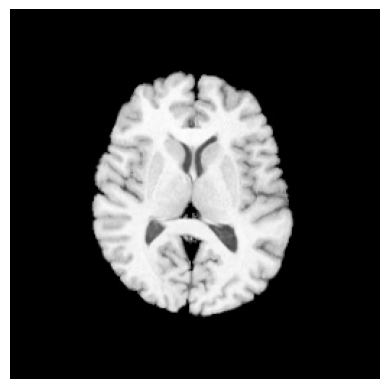

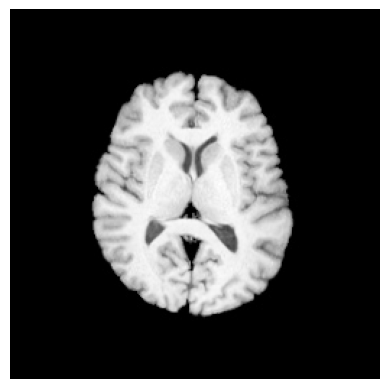

In [7]:
img2 = ants.n4_bias_field_correction(img)
ants.plot(img)
ants.plot(img2)

### Registration

You may need at some point need to align two images to each other. This task is called `registration`, and it can be done to varying degrees in terms of how much you change the image. Here is a general overview of the three main types of registration we will cover.

- Rigid: put two images in generally the same location using only translation and rotation
- Affine: make two images have the same general location and size using rigid translations + shearing and scaling
- SyN: align the actual features of two images using non-linear warping / distortion fields

You can see how these different types of registration alter the `moving` image to fit the `fixed` image.

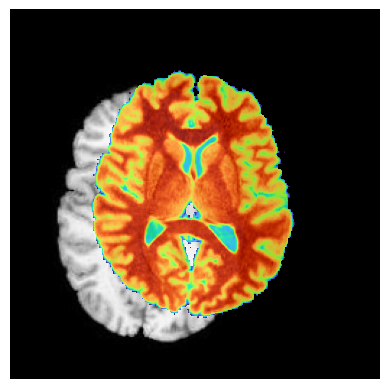

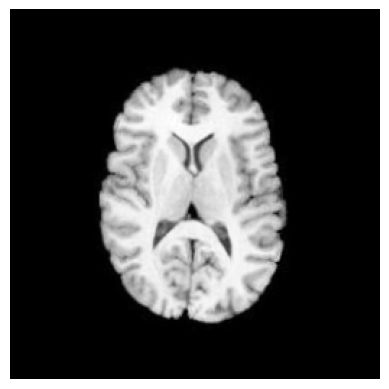

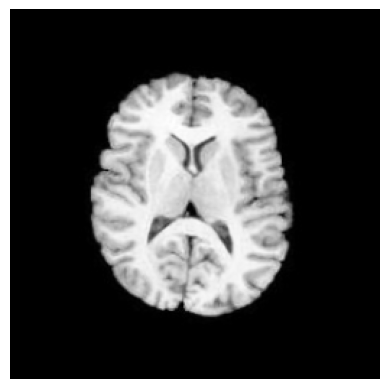

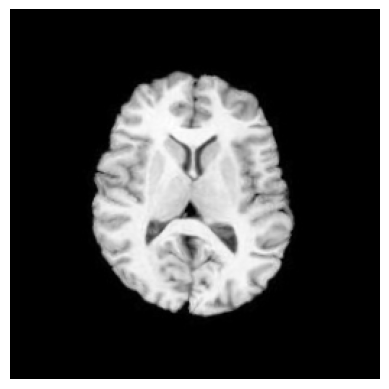

In [8]:
fixed = ants.image_read(ants.get_data('r16'))
moving = ants.image_read(ants.get_data('r64'))

res_rigid = ants.registration(fixed, moving, type_of_transform='Rigid')
res_affine = ants.registration(fixed, moving, type_of_transform='Affine')
res_syn = ants.registration(fixed, moving, type_of_transform='SyN')

ants.plot(moving, fixed)
ants.plot(res_rigid['warpedmovout'])
ants.plot(res_affine['warpedmovout'])
ants.plot(res_syn['warpedmovout'])

The Affine and SyN registration may look quite similar to each other, but the difference is perhaps most visible in the ventricles of the two images. Notice how the SyN-registered moving image has wider ventricles to match that of the fixed image compared to the relatively narrower ventricles in the original moving image. We can visualize this difference by subtracting the two images from each other.

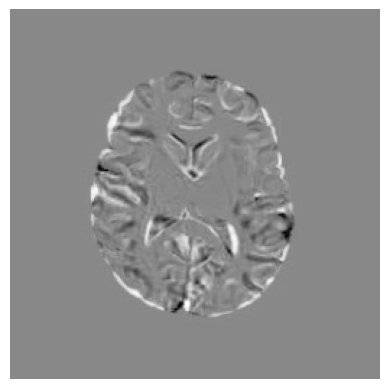

In [9]:
ants.plot(res_affine['warpedmovout'] - res_syn['warpedmovout'])

The white areas in the image show where tissue in the SyN-registered image has been expanded outward compared to the Affine-registered image. You can also get an understanding of non-linear registration results using the so-called Jacobian image. For those that are interested in going further with medical image registration, the ants library will get you far. The ants registration algorithms still make up a vital part of many traditional image processing pipelines.

### Segmentation

The ants library provides a few algorithms for segmentation. The most relevant one may be the `get_mask` function, which simply provides you with a binary mask that only includes the relevant part of the image. This is useful because, as mentioned, medical images often have a lot of empty space.

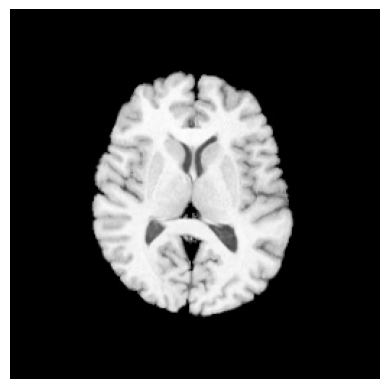

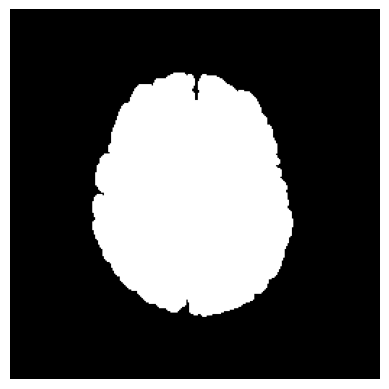

In [10]:
mask = ants.get_mask(img)
ants.plot(img)
ants.plot(mask)

Many other functions in ants take in a `mask` argument so that you can operate only on the part of the image with information. This greatly improves the efficiency and accuracy of results.

The other main algorithm for segmentation is atropos, which provides three-class tissue segmentation for brain images. This function will identify the ventricles, gray matter, and white matter regions in the image. Aptly, you include a mask when performing atropos.

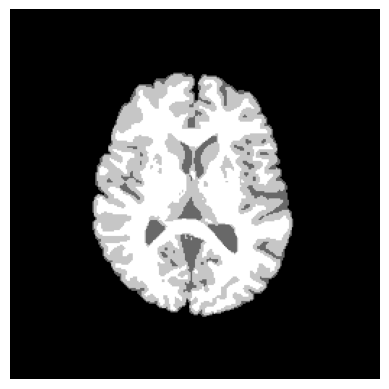

In [11]:
res = ants.atropos(img, mask)
ants.plot(res['segmentation'])

## Intensity

Key image operations include morphological functions such as opening and closing. These functions are particularly useful when you are working with segmentation images with discrete labels or masks. 

### Opening

When you open an image, it generally makes the image values expand.

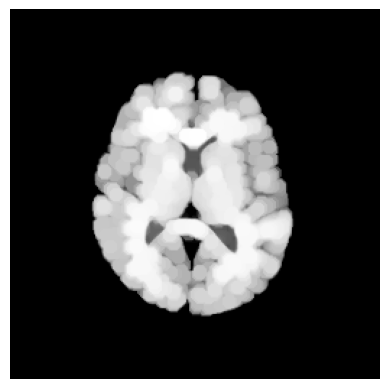

In [12]:
img2 = ants.iMath_GO(img, 4)
ants.plot(img2)

### Closing

Conversely, when you close an image it generally makes the images shrink a bit in terms of where the image is.

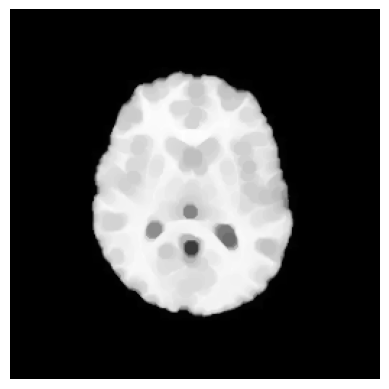

In [13]:
img2 = ants.iMath_GC(img, 4)
ants.plot(img2)

### Truncating

Truncating the intensity of image values is also important when training medical imaging AI models because it can remove strong outlier values - particularly those that are much more intense than expected.

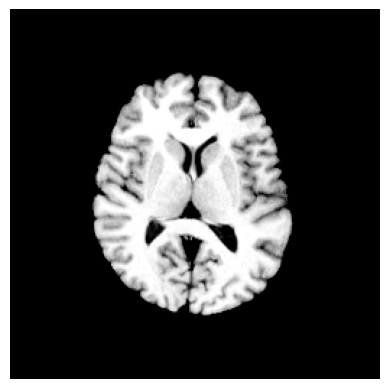

In [14]:
img2 = ants.iMath_truncate_intensity(img, 0.1, 0.9)
ants.plot(img2)

### Thresholding

An operation closely related to truncating intensity is thresholding. The thresholding operation works exactly as you expect: it only keeps intensity values above a certain threshold.

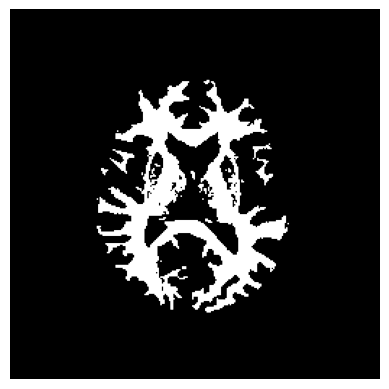

In [15]:
img2 = ants.threshold_image(img, 200)
ants.plot(img2)

### Normalizing

Normalizing image intensity values to be between 0 and 1 is also a common transform that is applied to images as a preprocessing step.

In [16]:
img2 = ants.iMath_normalize(img)
print(f'Original: min: {img.min()}, max: {img.max()}')
print(f'Normalized: min: {img2.min()}, max: {img2.max()}')

Original: min: 0.0, max: 254.0
Normalized: min: 0.0, max: 1.0


### Smoothing

Another important function is smoothing images. This can be important for removing finer details in the image that may not be important to the model.

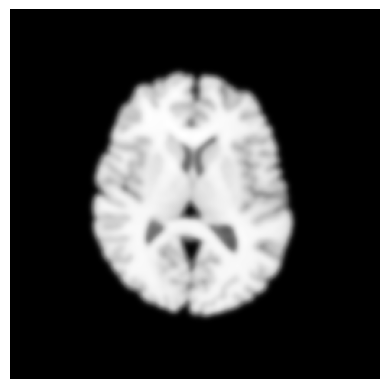

In [17]:
img2 = ants.smooth_image(img, 2)
ants.plot(img2)

## Spatial

Spatial functions are those that alter how the image structure appears. This primarily involves applying ants transforms to images. These transforms are exactly what you get from running registration, but there is nothing stopping you from applying those transforms to other images or from creating them yourself.

Let's create a transform ourself and apply it to an image. This concept will help you better understand how data augmentation is performed later on when we generate image batches for our medical imaging AI models.

In [18]:
ants.apply_ants_transform_to_image(img)

TypeError: apply_ants_transform_to_image() missing 2 required positional arguments: 'image' and 'reference'

## Structural

Structural operations can be considered as those which change the size of the image without altering how the image appears. The primary structural operations are padding and cropping images. These functions are greatly useful for getting all the images in your dataset to be the same size, as is required by most medical imaging AI models.

### Padding

Padding an image is done by supplying a new image shape or an amount by which you wish to pad your images.

In [20]:
img2 = ants.pad_image(img, pad_width=(40,40))
print('Original shape:', img.shape)
print('Padded shape:', img2.shape)

Original shape: (256, 256)
Padded shape: (296, 296)


### Cropping

When you crop an image, you do so based on a mask or other label image. This works well in tandem with the `get_mask` function to remove empty space from your images.

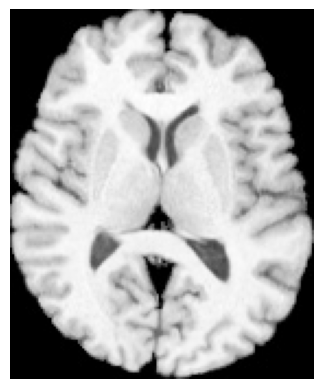

In [21]:
img2 = ants.crop_image(img, mask)
ants.plot(img2)

### Slicing 

Another spatial operation is slicing. Because 3D medical images are so large in size and dense in information, we often resort to training on only 2D slices of the 3D images. Getting slices of images can be done easily in ants.

In [22]:
img3d = ants.image_read(ants.get_data('mni'))
img_slice = ants.slice_image(img3d, axis=0, idx=128)
print(img3d)
print(img_slice)

ANTsImage (RPI)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (182, 218, 182)
	 Spacing    : (1.0, 1.0, 1.0)
	 Origin     : (-90.0, 126.0, -72.0)
	 Direction  : [ 1.  0.  0.  0. -1.  0.  0.  0.  1.]

ANTsImage
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (218, 182)
	 Spacing    : (1.0, 1.0)
	 Origin     : (126.0, -72.0)
	 Direction  : [-1.  0.  0.  1.]



Notice that when the image is sliced, much of the metadata such as origin and direction was maintained. This helps you maintain the greater context of the image slice for later.

## Summary

In this chapter, you learned about some basic preprocessing steps that can be taken to get your images into a trainable format. You also saw an overview of many of the core image operations that are available to you in the ants library. This included intensity, spatial, and structural operations.

We presented these operations to you here because they are vital to training medical imaging AI models. Some operations will be used only for preprocessing your imaging datasets, but others will make up the foundation of random transforms that you will apply to your images for data augmentation.

Data augmentation is the process of slightly changing your images in random ways in order to show your model a greater diversity of training data. This is a key feature of getting the most out of the fairly repetative structure of medical images. Now that you know about image operations in ants, learning about data augmentation later on will be much easier.